In [7]:
import matplotlib.pyplot as plt
import numpy as np
from maxentnuc.analysis.analysis import *
import os
from neighbor_balance.plotting import ContactMap, format_ticks, get_distance_average, apply_matplotlib_style, stylize_gene_name
from maxentnuc.simulation.upper_triangular import triu_to_full

apply_matplotlib_style()

mei_runs = '/orcd/data/binz/001/joepaggi/mei_runs'

No data root found, set manually.


In [8]:
def kernel_smooth(x, y, bw):
    d = np.abs(x.reshape(-1, 1) - x.reshape(1, -1))
    w = np.exp(-d**2 / (2*bw**2))
    w /= w.sum(axis=1)
    return np.sum(w * y, axis=1)

def add_contact_scaling(axs, cmap, name, color=None):
    ContactMap(cmap, 'chrom', 0, cmap.shape[0]*200, 200).plot_distance_average(label=name, ax=axs[0], color=color)
    y = get_distance_average(cmap, show_self=False)
    x = np.arange(200, (y.shape[0] + 1)*200, 200)
    y_smooth = kernel_smooth(np.log10(x), y, 0.1)
    slope_smooth = (np.log10(y_smooth[1:]) - np.log10(y_smooth[:-1])) / (np.log10(x[1:]) - np.log10(x[:-1]))
    axs[1].plot((x[1:] + x[:-1]) / 2, slope_smooth, label=name, color=color)

def plot_contact_scaling(conditions, ref_cmap=None, ref_cmap_name=None, sim_contacts_suffix='_simulated_contact_map.npy'):
    f, axs = plt.subplots(2, figsize=(3, 2.5), sharex='col', gridspec_kw={'hspace': 0.06})
    
    if ref_cmap is not None:
        add_contact_scaling(axs, ref_cmap, ref_cmap_name, color='black')
    for name, info in conditions.items():
        if 'contacts' in info:
            fname = info['contacts']
        else:
            fname = f'{info["base"]}{sim_contacts_suffix}'
        cmap = triu_to_full(np.load(fname))
        add_contact_scaling(axs, cmap, name)

    axs[0].set_ylim(1e-5, 1)
    axs[0].legend(bbox_to_anchor=(1, 1))
    axs[1].set_ylim(-2.5, 0)
    axs[0].set_ylabel('Contact frequency')
    axs[1].set_ylabel('Slope')
    format_ticks(axs[1], y=False)
    return axs


def plot_distance_scaling(conditions):
    separations = np.unique(np.logspace(0, 6, 100).astype(int))
    res = 1
    bp_per_bead = 200

    def power_law(x, a, b):
        return a*x**b

    f, ax = plt.subplots(2, figsize=(3, 2.5), sharex='col', gridspec_kw={'hspace': 0.06})
    for name, info in conditions.items():
        positions = load_polymer(info['psf'], info['dcd'], info['selection'], skip=11, scale=info['scale'], pad=250, burnin=0.0)
        n = positions[0].shape[0]
        _separations = np.concatenate([separations[separations < n], [n - 1]])
        y = []
        for separation in _separations:
            distances = get_distances(positions, separation)
            y += [np.mean(distances)]
        y = np.array(y)
        x = bp_per_bead * res * _separations

        popt, _ = curve_fit(power_law, x, y)
        a, b = popt
        print(name, a, b)
        ax[0].plot(x, y, label=name)
        #ax[0].scatter(x, y)

        slope = (np.log10(y[1:]) - np.log10(y[:-1])) / (np.log10(x[1:]) - np.log10(x[:-1]))
        ax[1].plot((x[1:] + x[:-1]) / 2, slope, label=name)

    ax[0].set_yscale('log')
    ax[0].set_xscale('log')
    ax[0].legend(fontsize=6, loc='upper left')
    format_ticks(ax[1], y=False)
    ax[0].set_ylabel('Distance (nm)')
    
    ax[1].set_ylabel('Slope')
    ax[1].set_ylim(0, 0.75)
    ax[0].set_xlim(200, 2_000_000)
    ax[1].axhline(1/3, c='grey', ls='--')
    ax[1].axhline(1/2, c='grey', ls='--')
    ax[1].set_yticks([0, 1/3, 1/2], ['0', '1/3', '1/2'])
    return f, ax

    
def plot_concentrations(conditions, cuts=(25, 30, 40, 50, 60, 70, 80, 90, 100)):
    means = np.zeros((len(conditions), len(cuts)))
    names = []
    for j, (name, info) in enumerate(conditions.items()):
        names += [name]
        trajectory = load_polymer(info['psf'], info['dcd'], info['selection'], skip=100, scale=info['scale'], pad=100, burnin=0.0)
        for i, cut in enumerate(cuts):
            neighbors = count_neighbors(trajectory, radius=cut).flatten()
            conc = to_micromolar(neighbors + 1, 4/3 * np.pi * cut**3)
            means[j, i] = np.mean(conc)

    plt.figure(figsize=(3, 2))
    plt.plot(cuts, means.T, label=names)
    plt.legend()
    plt.xlabel('radius (nm)')
    plt.ylabel('concentration (µM)')
    plt.ylim(0)

In [9]:
conditions = {
    'nanog': {'base': f'{mei_runs}/nanog/v36/018', 'scale':0.1},
    'klf1': {'base': f'{mei_runs}/klf1/v3/011', 'scale':0.1},
    'ppm1g': {'base': f'{mei_runs}/ppm1g/v2/010', 'scale':0.1},
    'sox2': {'base': f'{mei_runs}/sox2/v11/013', 'scale':0.1},
    'fbn2': {'base': f'{mei_runs}/fbn2/v2/012', 'scale':0.1},
}
conditions = {stylize_gene_name(key): value for key, value in conditions.items()}
conditions = expand_conditions(conditions)

# Compare different regions

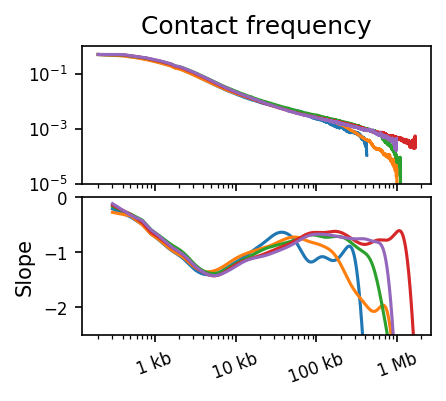

In [10]:
f, axs = plt.subplots(2, figsize=(3, 2.5), sharex='col', gridspec_kw={'hspace': 0.1})
for name, info in conditions.items():
    cmap = np.load(f'{os.path.dirname(info["base"])}/processed_contact_map.npy')
    add_contact_scaling(axs, cmap, name)
axs[0].set_ylim(1e-5, 1)
axs[1].set_ylim(-2.5, 0)
axs[0].set_title('Contact frequency')
axs[1].set_ylabel('Slope')
format_ticks(axs[1], y=False)
plt.savefig('img/scaling_contacts.pdf')
plt.show()

/home/joepaggi/miniconda3/envs/neighbor/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/joepaggi/miniconda3/envs/neighbor/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:326: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


$\mathit{Nanog}$ 3.6856411960628668 0.373949502786138
$\mathit{Klf1}$ 4.027332718585756 0.36184866232279944
$\mathit{Ppm1g}$ 6.973934683502412 0.2961190765661799
$\mathit{Sox2}$ 11.185791583780919 0.2560759180820603
$\mathit{Fbn2}$ 6.349886385685136 0.3112442188486626


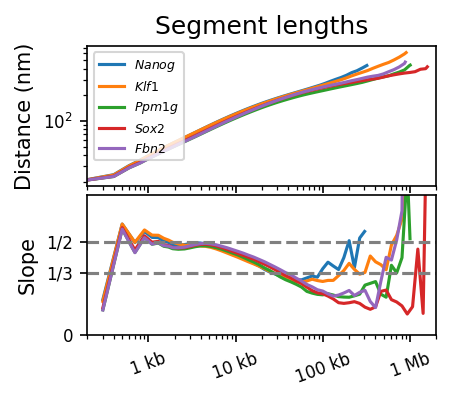

In [11]:
f, ax = plot_distance_scaling(conditions)
ax[0].set_title('Segment lengths')
plt.savefig('img/scaling_distances.pdf')
plt.show()

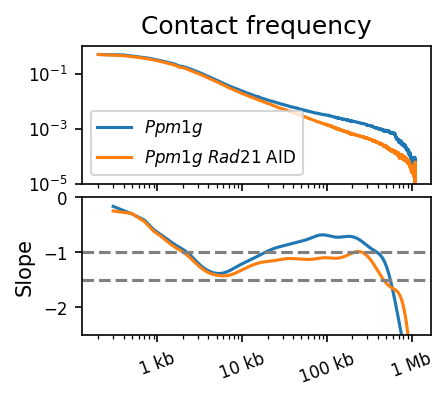

In [6]:
wt = stylize_gene_name('ppm1g')
rad21 = stylize_gene_name('ppm1g') + ' ' + stylize_gene_name('rad21') + ' AID'

conditions = {
    wt: {'base': f'{mei_runs}/ppm1g/v2/010', 'scale':0.1},
    rad21: {'base': f'{mei_runs}/ppm1g/v4/024', 'scale':0.1},
   # 'ppm1g_rad21_aid_high': {'base': f'{mei_runs}/ppm1g/v4/015', 'scale':0.1},
    #'ppm1g_rad21_aid_low': {'base': f'{mei_runs}/ppm1g/v4/008', 'scale':0.1},
}
conditions = expand_conditions(conditions)

f, axs = plt.subplots(2, figsize=(3, 2.5), sharex='col', gridspec_kw={'hspace': 0.1})
for color, name in [('red', wt), ('blue', rad21)]:
    info = conditions[name]
    cmap = np.load(f'{os.path.dirname(info["base"])}/processed_contact_map.npy')
    add_contact_scaling(axs, cmap, name)
axs[0].set_ylim(1e-5, 1)
axs[0].legend()
axs[1].set_ylim(-2.5, 0)
axs[0].set_title('Contact frequency')
axs[1].set_ylabel('Slope')
axs[1].axhline(-1, c='grey', ls='--')
axs[1].axhline(-1.5, c='grey', ls='--')
format_ticks(axs[1], y=False)
plt.savefig('img/scaling_contacts_rad21.pdf')
plt.show()

/home/joepaggi/miniconda3/envs/neighbor/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/joepaggi/miniconda3/envs/neighbor/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:326: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


$\mathit{Ppm1g}$ 6.973934683502412 0.2961190765661799
$\mathit{Ppm1g}$ $\mathit{Rad21}$ AID 1.7197616443240387 0.448997734245909


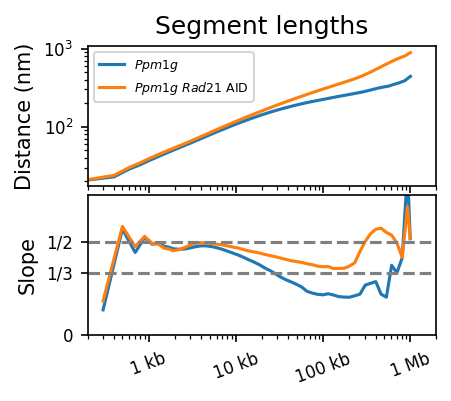

In [7]:
f, ax = plot_distance_scaling(conditions)
ax[0].set_title('Segment lengths')
plt.savefig('img/scaling_distances_rad21.pdf')

# Impact of changing nucleosome interactions

In [ ]:
conditions = {
    '0.0 kT': {'base': f'{mei_runs}/nanog/v39/023', 'scale': 1/10},   # This one has an initial alpha of -0.02.
    '0.8 kT': {'base': f'{mei_runs}/nanog/v40/018', 'scale': 1/10},
    '1.0 kT': {'base': f'{mei_runs}/nanog/v36/018', 'scale': 1/10},
    '1.2 kT': {'base': f'{mei_runs}/nanog/v41/018', 'scale': 1/10},
    '1.4 kT': {'base': f'{mei_runs}/nanog/v43/022', 'scale': 1/10},
    'rc15':   {'base': f'{mei_runs}/nanog/v44/024', 'scale': 1/10},
}
conditions = expand_conditions(conditions)

plot_distance_scaling(conditions)
plt.savefig('img/scaling_distance_opt_nanog.pdf')
plt.show()

cmap = np.load(f'{mei_runs}/nanog/v36/processed_contact_map.npy')
plot_contact_scaling(conditions, cmap, 'nanog rcmc')
plt.savefig('img/scaling_contacts_opt_nanog.pdf')
plt.show()

plot_concentrations(conditions)
plt.savefig('img/scaling_conc_opt_nanog.pdf')
plt.show()

/home/joepaggi/miniconda3/envs/neighbor/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/joepaggi/miniconda3/envs/neighbor/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:326: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


0.0 kT 8.509234957838375 0.2718230035649734
0.8 kT 5.108344118008826 0.3364756824563918
1.0 kT 3.6856411960628668 0.373949502786138
1.2 kT 3.7252059920540446 0.378603994499907
1.4 kT 3.3410252332153267 0.39370475194746285


0.0 kT 1.4540232714571883 0.5320790444403815
0.8 kT 1.1990777629273885 0.5107342544073519
1.0 kT 12.75015210784135 0.21248097224290685
1.2 kT 13.035607822989618 0.19548344338763923
1.4 kT 12.73387741827402 0.19048898524846913


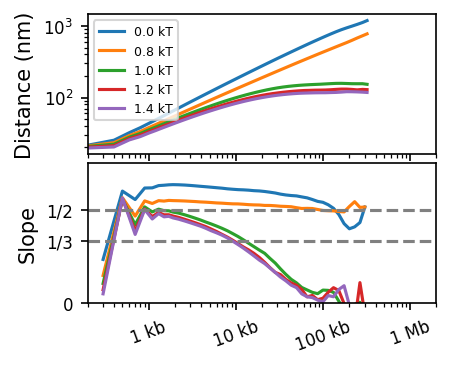

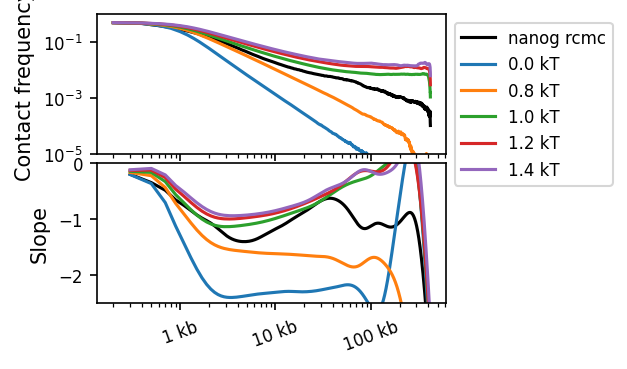

/home/joepaggi/miniconda3/envs/neighbor/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"
/home/joepaggi/miniconda3/envs/neighbor/lib/python3.12/site-packages/MDAnalysis/coordinates/DCD.py:326: DeprecationWarning: asel argument to timeseries will be renamed to'atomgroup' in 3.0, see #3911
  warnings.warn(


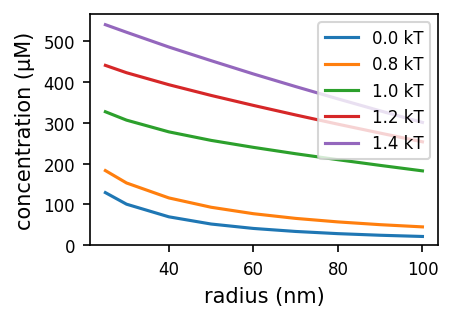

In [ ]:
conditions = {
    '0.0 kT': {'base': f'{mei_runs}/nanog/v38/000', 'scale': 1/10},  # This one has an initial alpha of 0.
    '0.8 kT': {'base': f'{mei_runs}/nanog/v40/000', 'scale': 1/10},
    '1.0 kT': {'base': f'{mei_runs}/nanog/v36/000', 'scale': 1/10},
    '1.2 kT': {'base': f'{mei_runs}/nanog/v41/000', 'scale': 1/10},
    '1.4 kT': {'base': f'{mei_runs}/nanog/v43/000', 'scale': 1/10},
}
conditions = expand_conditions(conditions)

plot_distance_scaling(conditions)
plt.savefig('img/scaling_distance_noopt_nanog.pdf')
plt.show()

cmap = np.load(f'{mei_runs}/nanog/v36/processed_contact_map.npy')
plot_contact_scaling(conditions, cmap, 'nanog rcmc')
plt.savefig('img/scaling_contacts_noopt_nanog.pdf')
plt.show()

plot_concentrations(conditions)
plt.savefig('img/scaling_conc_noopt_nanog.pdf')
plt.show()